# Steady state and stability analysis
Catalyst supports both the computation of system steady states (using various packages) and also bifurcation analysis and the creation of bifurcation diagrams (using BifurcationKit.jl). Here we will briefly demonstrate both approaches. 

## Steady state computation
Primarily, Catalyst computes the steady states of reaction networks through homotopy continuation. This is implemented through the HomotopyContinuation.jl package. While this method is limited to systems of (rational) polynomial systems, it guarantees to find all steady state solutions. Since most reaction networks fulfill the polynomial criteria, generally, homotopy continuation is the recommended method.

In our example, we will use the model from *Wilhelm, BMC Systems Biology (2009)*, which exhibits multiple steady states for some parameter values. We first declare the model and the parameter set of interest.

In [1]:
using Catalyst

wilhelm_2009_model = @reaction_network begin
    k1, Y --> 2X
    k2, 2X --> X + Y
    k3, X + Y --> Y
    k4, X --> 0
end
ps = [:k1 => 8.0, :k2 => 2.0, :k3 => 1.0, :k4 => 1.5]

4-element Vector{Pair{Symbol, Float64}}:
 :k1 => 8.0
 :k2 => 2.0
 :k3 => 1.0
 :k4 => 1.5

Next, we use the `hc_steady_states` function to retrieve the steady states.

In [2]:
using HomotopyContinuation
hc_steady_states(wilhelm_2009_model, ps)

UndefVarError: UndefVarError: `hc_steady_states` not defined

## Network analysis and systems with conservation laws


Some systems have conserved quantities. Here the steady states depend on the initial conditions and cannot be computed from the system directly. E.g. for a two state model, where a species switches between two states `X1` and `X2`, the steady state depend on the total amount of `X` (`X1`+`X2`) in the system. If we print the ODE system, we can see that both equations are identical, and hence not enough for finding the steady states.

In [ ]:
using Latexify
two_state_model = @reaction_network begin
    (k1,k2), X1 <--> X2
end
latexify(two_state_model; form=:ode)

Catalyst contain a suite of functions for network analysis, which includes the ability to compute conservation equations. To find the steady states, this needs to be added to the system:

In [ ]:
conservedequations(two_state_model)

In practise, the `hc_steady_states` function handles this automatically, as long as we give some initial condition:

In [ ]:
ps = [:k1 => 2.0, :k2 => 1.0]
u0 = [:X1 => 1.0, :X2 => 1.0]
hc_steady_states(wilhelm_2009_model, ps; u0)

## Bifurcation Analysis
*Bifurcation diagrams* allow us to plot how a systems steady states depend on a parameter. These are named after so called *bifurcation points*, places where the quantity and/or quality of the teh system's steady states change. Catalyst links to the BifurcationKit package for bifurcation analysis. This allow us to e.g. compute bifurcation diagrams. Here we will compute a bifurcation diagram for a simple bistable switch (where a single component, `X`, activates its own production through a Hill function.)

We are currently working on a new interface, which is not finalised or available online, so we will isntead import a working version from a local file (using the `include` function).

In [5]:
using BifurcationKit
include("bifurcation_problem_interface.jl")

The first step is to declare 
- The model for which we wish to compute the bifurcation diagram.
- The parameter set for which we wish to compute the bifurcation diagram.
- The parameter we wish to vary in the bifurcation diagram.
- The interval over which we wish to vary this parameter.
- The species concentration we wish to plot on the y-axis.

Here we investigate how teh steady states change as the parameter `K` is varies between teh values `10` and `200`.

In [6]:
bistable_switch = @reaction_network begin
    v0 + hill(X,v,K,n), ∅ --> X
    deg, X --> ∅
end
ps = [:v0 => 0.1, :v => 2.5, :K => 75.0, :n => 2.0, :deg => 0.01];
p = :K
p_span = (10.0, 200.0)
s = :X;

Next, we couple all of this information into a `Bifurcationproblem`.

In [7]:
b_prob = BifurcationProblem(bistable_switch, ps, p, p_span, s);

Next, we have to prepare the settings for the bifurcation algorithm. There are many alternative ones, but here we will simply increase the maximum number of steps of the path-tracking algorithm, and set the maximum and minimum parameter values (identical to `p_span`).

In [8]:
opts_br = ContinuationPar(max_steps = 10000, p_min = p_span[1], p_max = p_span[2]);

Next, we use our bifurcation problem and our settings as an input to the `bifurcationdiagram` function, and plot teh result.

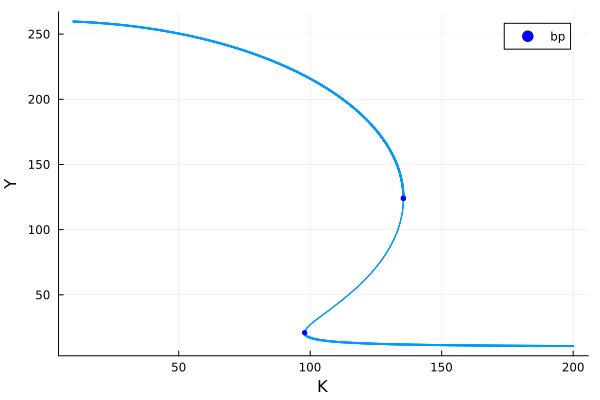

In [9]:
bf = bifurcationdiagram(b_prob, PALC(), 2, (args...) -> opts_br)

using Plots
plot(bf; xguide="K", yguide="Y")

Here we see a region of bistability (two stable steady states separated by an unstable one) as K is varied. The two bifurcation points are marked (both fold bifurcations).